# Input Files for the Model
The notebook contains the code for generating input files for the running the idealized channel model. The files include analytical profiles of forcings, restoration and sponge. A generic topography is also generated.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

import initialization_functions as infs

$\large \text{Generate Mercator Grid}$

In isotropic mercator grid, all cell boxes are squares to reduce grid distortion. Here, the meridional grid spacing ($\Delta \phi$) decreases towards the poles as
$$\Delta \phi = \Delta \lambda \cos(\phi)$$
where $\Delta \lambda$ and $\phi$ are the zonal grid spacing (in degrees) and latitude, respectively.The resulting latitude traced points are given as (assuming j = 0 for equator),

$$\phi (j) = \frac{\pi}{180} \arcsin \left[\tanh(j\pi/180)\right]$$

Either use this code or read grid info from a file as in the code below

In [2]:
# Determine lat-lon tracer points
R_E = 6.378e6

lats, latn = (-70., -30.)
lonw, lone = (0., 80.)

res = 0.25  # Grid resolution
lon = np.arange(lonw + res/2., lone, res)

ind = np.arange(-397, -125); # indices for 0.25 deg resolution, adjust ind based on resolution

lat = (180/np.pi)*np.arcsin(np.tanh(res*np.pi*ind/180)) 

dlat = res * np.cos(lat * np.pi/180)
dlon = np.ones(len(lon)) * res

# Compute grid spacing in m
Long, Lati = np.meshgrid(lon, lat)
dx, dy = np.meshgrid(dlon, dlat)

dx = dx * np.cos(Lati * np.pi/180.) * (2*np.pi*R_E/360.)
dy = dy * (2*np.pi*R_E/360.)

In [3]:
DX = xr.DataArray(dx,coords=[("yh",lat), ("xh",lon)])
DY = xr.DataArray(dy,coords=[("yh",lat), ("xh",lon)])

X,Y = infs.calc_XYmeters_gen(DX.yh, DX.xh, DX, DY, 'yh', 'xh',center_x = True)

Text(0.5, 1.0, 'dy')

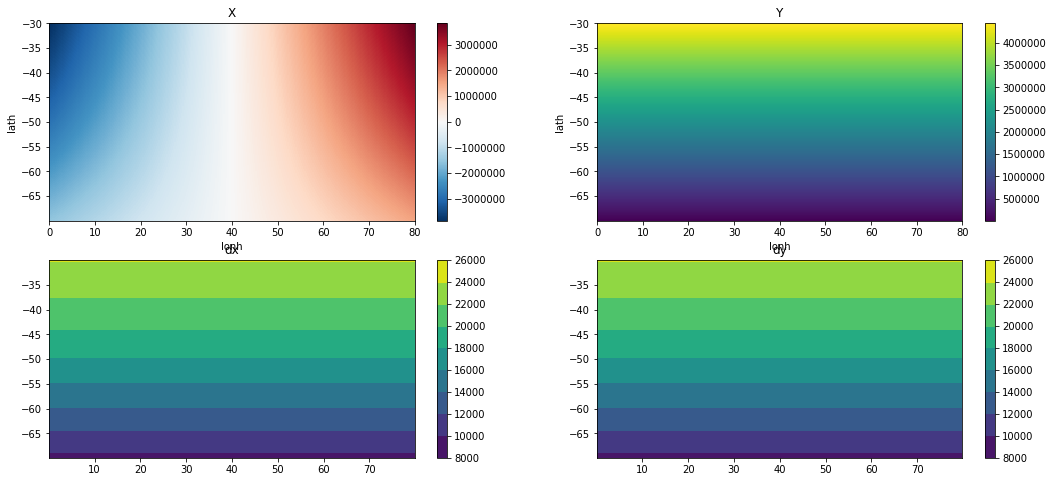

In [4]:
fig = plt.figure(figsize=[18,8])

plt.subplot(2,2,1)
X.plot()
plt.title('X')

plt.subplot(2,2,2)
Y.plot()
plt.title('Y')

plt.subplot(2,2,3)
plt.contourf(lon, lat, dx)
plt.colorbar()
plt.title('dx')

plt.subplot(2,2,4)
plt.contourf(lon, lat, dy)
plt.colorbar()
plt.title('dy')

$\large \text{Mosaic Grid}$

If mosaic grid option is chosen in MOM6, then grid coordinates (x ,y in deg.), grid spacings (dx, dy in meters) and cell areas (in m^2) need to be provided. These arrays contain both cell center and corner points; therefore, array sizes are (2 * Ny + 1, 2 * Nx + 1). The function below generates required arrays. 

Note - In isotropic mercator grid, zonal and meridional extent are not independent of number of grid points. The model may return error, if the the numbers are not consistet. In that case, supplying grid info may be an easier option.  

In [5]:
def grid_mosaic(lat, lon, dlat, dlon, R_E):
        
    Ny = lat.shape[0]
    Nx = lon.shape[0]
    
    # Number of points for arrays in the grid file
    nyp = 2*Ny + 1; nxp = 2*Nx + 1
    ny = 2*Ny; nx = 2*Nx
    
    # define arrays
    x1 = np.zeros([nyp, nxp])
    y1 = np.zeros([nyp, nxp])
    area1 = np.zeros([ny, nx])
    
    for i in range(0,nyp):
        x1[i,0:nxp-1:2] = lon - dlon/2.
        x1[i:,1::2] = lon
        x1[i,nxp-1] = lon[Nx-1] + dlon[Nx-1]/2.
    
    for i in range(0,nxp):
        y1[0:nyp-1:2,i] = lat - dlat/2.
        y1[1::2, i] = lat
        y1[nyp-1,i] = lat[Ny-1] + dlat[Ny-1]/2.
    
    dx1 = np.diff(x1,axis=1)
    dy1 = np.diff(y1,axis=0)
    
    dx1 = dx1 * np.cos(y1[:,0:nx] * np.pi/180.) * (2*np.pi*R_E/360.)
    dy1 = dy1 * (2*np.pi*R_E/360.)
    
    for j in range(0, ny):
        for i in range(0, nx):
            
            area1[j,i] = dx1[j,i] * dy1[j,i]
    
    grid = xr.Dataset()
    
    grid['x'] = xr.DataArray(x1,dims=['nyp','nxp'])
    grid['y'] = xr.DataArray(y1,dims=['nyp','nxp'])
    grid['dx'] = xr.DataArray(dx1,dims=['nyp','nx'])
    grid['dy'] = xr.DataArray(dy1,dims=['ny','nxp'])
    grid['area'] = xr.DataArray(area1,dims=['ny','nx'])
    
    return grid

In [6]:
grid = grid_mosaic(lat, lon, dlat, dlon, R_E)

grid.to_netcdf('../../MOM6_Channel_Input/hgrid'+'.nc')

In [7]:
grid

<xarray.Dataset>
Dimensions:  (nx: 640, nxp: 641, ny: 544, nyp: 545)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    x        (nyp, nxp) float64 0.0 0.125 0.25 0.375 ... 79.62 79.75 79.88 80.0
    y        (nyp, nxp) float64 -69.98 -69.98 -69.98 ... -29.92 -29.92 -29.92
    dx       (nyp, nx) float64 4.764e+03 4.764e+03 ... 1.206e+04 1.206e+04
    dy       (ny, nxp) float64 4.773e+03 4.773e+03 ... 1.205e+04 1.205e+04
    area     (ny, nx) float64 2.274e+07 2.274e+07 ... 1.451e+08 1.451e+08

$\large \text{Vertical grid and layer densities} $

In [18]:
# Vertical grid
nk = 75
max_depth = 4000.
min_depth = 0.
thkcello_topcell = 1.
method = 'powerlaw'

vgrid = infs.calc_vgrid(nk=nk,max_depth=max_depth,min_depth=min_depth,
                        thkcello_topcell=thkcello_topcell,method=method)

density = xr.open_dataset('../../Baltic_Files/hycom1_75_800m.nc')
sigma2 = xr.DataArray(density.sigma2.values,coords=[vgrid['NKp1']],dims=['NKp1'])

vgrid = xr.merge([vgrid, sigma2.rename("sigma2")])

d = xr.DataArray((vgrid['sigma2'].values[1:] + vgrid['sigma2'].values[:-1]) / 2.,coords=[vgrid['NK']],dims=['NK'])
vgrid = xr.merge([vgrid, d.rename("Layer")])

vgrid.to_netcdf('../../MOM6_Channel_Input/vgrid'+'.nc')

In [19]:
vgrid

<xarray.Dataset>
Dimensions:  (NK: 75, NKp1: 76)
Coordinates:
  * NKp1     (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
  * NK       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
Data variables:
    zw       (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
    zt       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
    dz       (NK) float64 1.0 2.787 4.465 6.089 ... 98.04 99.31 100.6 101.8
    sigma2   (NKp1) float64 1.01e+03 1.014e+03 1.018e+03 ... 1.038e+03 1.038e+03
    Layer    (NK) float64 1.012e+03 1.016e+03 1.019e+03 ... 1.038e+03 1.038e+03

$\large \text{Surface Forcing Files}$ 

Zonally uniform forcing profiles are created for wind stress and surface fluxes. These profiles inspired from SOSE and OM4 dataset (see SOSE_Forcing notebook and MOM6_example_forcing). The general form of the function is
$$f(y) = \sin\left(y + \frac{b}{2}\sin(a\cdot y)\right)^c$$
a, b, c coefficients control the shape and skewness of the profile. Recommended values are a = 1 or 2; b = [-2, 2] and c = 1 or 2.

In [20]:
# Wind Forcing

sponge_width = 1. # In degrees

taux_east = 0.15
taux_west = 0.05
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 63.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = (np.max(Y.isel(lonh=0).values) - 
          Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) + sponge_width).argmin()).values)

wind = xr.Dataset()
wind['taux'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = taux_east, 
                                 max_south = taux_west, a=1., b=0.9, c=1., d=1., e=0, f=2.)

wind['tauy'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = 0., 
                                 max_south = 0., a=1., b=0.9, c=1., d=1., e=0, f=2.)

# Save
wind = wind.transpose('lath','lonh')
#wind.to_netcdf('../../MOM6_Channel_Input/wind'+'.nc')

In [113]:
# Surface Fluxes of heat

buoyancy = xr.Dataset()
buoyancy['zero_forc'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['LW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['SW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['latent'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['evap'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)


Buo_east = 20. # W/m^2
Buo_west = 10.
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 58.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) 
                                                                       + 2.).argmin()).values 

buoyancy['sensible'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = Buo_east, 
                                 max_south = Buo_west, a=1., b=1.5, c=1., d=1., e=0., f=1.)

# Surface fresh water fluxes

buoyancy['froz_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

Buo_east = -2.0e-5 # kg/m^2s
Buo_west = -1.6e-5
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 49.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) 
                                                                       + 2.).argmin()).values
buoyancy['liq_precip'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = Buo_east, 
                                 max_south = Buo_west, a=2., b=1.0, c=1., d=1., e=-1.5, f=1.)

Buo_east = 2.0e-5; Buo_west = 4.0e-5 # kg/m^2s
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 65.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) + 27.).argmin()).values
buoyancy['froz_precip'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = Buo_east, 
                                 max_south = Buo_west, a=2., b=1., c=1., d=2., e=1.0, f=2.)

# Save
buoyancy = buoyancy.transpose('lath','lonh')
#buoyancy.to_netcdf('../../MOM6_Channel_Input/buoyancy'+'.nc')

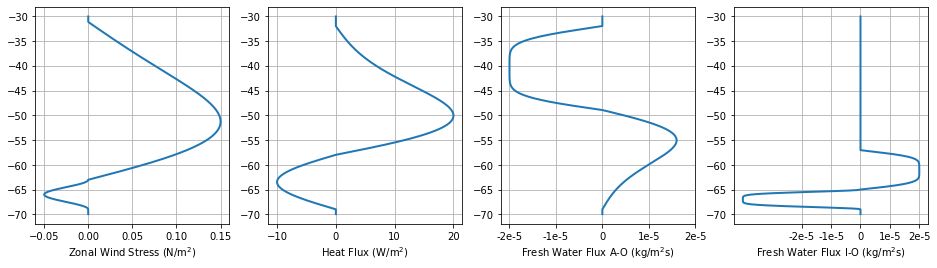

In [114]:
fig = plt.figure(figsize=[16,4])

plt.subplot(1,4,1)
plt.plot(wind['taux'].isel(lonh=0), wind['lath'],lw=2, label = 'Analytical')
plt.grid()
plt.xlabel('Zonal Wind Stress (N/m$^2$)')

plt.subplot(1,4,2)
plt.plot(buoyancy['sensible'].isel(lonh=0), buoyancy['lath'],lw=2,label = 'Analytical')
plt.xlabel('Heat Flux (W/m$^2$)')
plt.grid()

plt.subplot(1,4,3)
plt.plot(buoyancy['liq_precip'].isel(lonh=0), buoyancy['lath'],lw=2,label = 'Analytical')
plt.xticks([-2e-5, -1e-5, 0, 1e-5, 2e-5], ['-2e-5', '-1e-5', '0', '1e-5','2e-5'])
plt.xlabel('Fresh Water Flux A-O (kg/m$^2$s)')
plt.grid()

plt.subplot(1,4,4)
plt.plot(buoyancy['froz_precip'].isel(lonh=0), buoyancy['lath'],lw=2,label = 'Analytical')
plt.xticks([-2e-5, -1e-5, 0, 1e-5, 2e-5], ['-2e-5', '-1e-5', '0', '1e-5','2e-5'])
plt.xlabel('Fresh Water Flux I-O (kg/m$^2$s)')
plt.grid()

In [115]:
# Check Meridional integral of freshwater forcing
dA = (DX * DY) 
dA = dA.rename({'xh':'lonh','yh':'lath'})
dA = dA.isel(lonh=0)

int_A_O = (buoyancy['liq_precip'].isel(lonh=0) * dA).sum() / dA.sum()

int_I_O = (buoyancy['froz_precip'].isel(lonh=0) * dA).sum() / dA.sum()

print(int_A_O, int_I_O)

<xarray.DataArray ()>
array(-4.52253804e-06)
Coordinates:
    lonh     float64 0.125 <xarray.DataArray ()>
array(6.45342769e-07)
Coordinates:
    lonh     float64 0.125


$\large \text{Temperature and Salinity profiles}$

First, we use anlytical functions for sea surface potential temperature and salinity profiles. Then, we first compute surface density simplified nonlinear equation of state. Then, we use exponential profiles in vertical for potential temperature and density. Finally, use the simplified nonlinear equation of state relation to obtain salinity structure, which is difficult to set using analytical functions. Following this approach, we obtain realistically looking vertical profiles. 

In [23]:
def salinity_vallis_2006(rho, theta):

    # Simpler nonlinear equation of state (Nycander et al., 2015)
    g = 9.8; c = 1500.; 
    rho_0 = 1027.; theta_0 = 10; S_0 = 35.;
    z = 0.
    
    gamma_b = 1.1179*1.e-4; gamma_c = 1.e-5; 
    alpha = 1.67*1.e-4; beta = 0.78*1.e-3 
    
    b = -g * (rho - rho_0)/rho_0
    
    S = -b/g -g*z/c**2 + alpha*(1 + gamma_b * z)*(theta - theta_0) + 0.5 * gamma_c * (theta - theta_0)**2
    
    S = S / beta + S_0
    
    return S

def density_vallis_2006(S, theta):
    
    # Simpler nonlinear equation of state (Nycander et al., 2015)
    g = 9.8; c = 1500.; 
    rho_0 = 1027.; theta_0 = 10; S_0 = 35.;
    z = 0.
    
    gamma_b = 1.1179*1.e-4; gamma_c = 1.e-5; 
    alpha = 1.67*1.e-4; beta = 0.78*1.e-3
    
    b = g*(-g*z/c**2 + alpha*(1 + gamma_b * z)*(theta - theta_0) + 0.5 * gamma_c * (theta - theta_0)**2 - beta*(S-S_0))
    
    density = rho_0 - b*rho_0/g - 1000.  
    
    return density

In [26]:
# Temperature and salinity initial conditions
Tn = 22; Ts = -1.
Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 43.0).argmin()).values
Ws = 1.e6

TS = xr.Dataset()
TS['SST'] = infs.calc_distribution(coordinate = Y, function='tan_hyperbolic', val_at_maxcoord = Tn, 
                                   val_at_mincoord = Ts, Ys = Ys, Ws = Ws)

#Rs = 27.5; Rn = 25.
#TS['SS_rho'] = infs.calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Rn, val_at_mincoord = Rs)

#TS['SSS'] = xr.apply_ufunc(salinity_vallis_2006, TS['SS_rho'] + 1000., TS['SST'], dask='parallelized', 
#                          output_dtypes=[TS.SST.dtype])

Sn = 35.6; Ss = 34.0; Ws = 3.5e5
TS['SSS'] = infs.calc_distribution(coordinate = Y, function='tan_hyperbolic', val_at_maxcoord = Sn, 
                                   val_at_mincoord = Ss, Ys = Ys, Ws = Ws)

TS['SS_rho'] = xr.apply_ufunc(density_vallis_2006, TS['SSS'], TS['SST'], dask='parallelized', 
                             output_dtypes=[TS.SST.dtype])

#TS.to_netcdf('../../MOM6_Channel_Input/TS'+'.nc')

Text(0.5, 0, 'SSS')

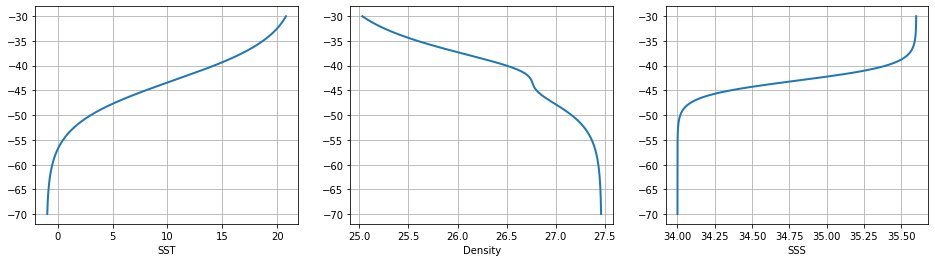

In [27]:
fig = plt.figure(figsize=[16,4])

plt.subplot(1,3,1)
plt.plot(TS['SST'].isel(lonh=0), TS['lath'],lw=2)
plt.grid()
plt.xlabel('SST')

plt.subplot(1,3,2)
plt.plot(TS['SS_rho'].isel(lonh=0), TS['lath'],lw=2)
plt.grid()
plt.xlabel('Density')

plt.subplot(1,3,3)
plt.plot(TS['SSS'].isel(lonh=0), TS['lath'],lw=2)
plt.grid()
plt.xlabel('SSS')

In [38]:
# Extend temperature, density and salinity in the vertical

TS['T'] = (infs.calc_distribution(coordinate=-vgrid.zt, function = 'exponential', 
                                  val_at_maxcoord = TS['SST'], efolding = 800))

rho = (infs.calc_distribution(coordinate=-vgrid.zt, function = 'exponential', 
                              val_at_maxcoord = TS['SS_rho'] - 27.8, efolding = 800))

TS['rho'] = (infs.calc_distribution(coordinate=-vgrid.zt,function='uniform',uniform_value = 27.8)
          + rho) 

TS['S'] = xr.apply_ufunc(salinity_vallis_2006, TS['rho'] + 1000., TS['T'], dask='parallelized', 
                         output_dtypes=[TS.SST.dtype])

TS = TS.transpose('NK','lath','lonh')

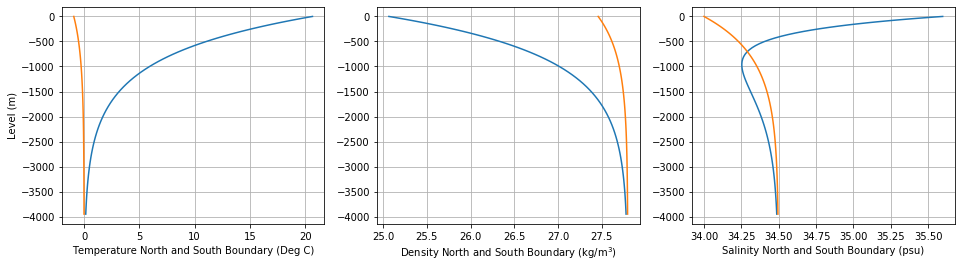

In [39]:
fig = plt.figure(figsize=[16,4])

plt.subplot(1,3,1)
plt.plot(TS['T'].isel(lonh=0).sel(lath=slice(-31,-30)).mean('lath'),-TS.NK)
plt.plot(TS['T'].isel(lonh=0).sel(lath=slice(-70,-69)).mean('lath'),-TS.NK)
plt.xlabel('Temperature North and South Boundary (Deg C)')
plt.ylabel('Level (m)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(TS['rho'].isel(lonh=0).sel(lath=slice(-31,-30)).mean('lath'),-TS.NK)
plt.plot(TS['rho'].isel(lonh=0).sel(lath=slice(-70,-69)).mean('lath'),-TS.NK)
plt.xlabel('Density North and South Boundary (kg/m$^3$)')
#plt.ylabel('Level (m)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(TS['S'].isel(lonh=0).sel(lath=slice(-31,-30)).mean('lath'),-TS.NK)
plt.plot(TS['S'].isel(lonh=0).sel(lath=slice(-70,-69)).mean('lath'),-TS.NK)
plt.xlabel('Salinity North and South Boundary (psu)')
#plt.ylabel('Level (m)')
plt.grid()

In [40]:
TS

<xarray.Dataset>
Dimensions:  (NK: 75, lath: 272, lonh: 320)
Coordinates:
  * lath     (lath) float64 -69.94 -69.85 -69.77 -69.68 ... -30.46 -30.24 -30.02
  * lonh     (lonh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * NK       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
Data variables:
    SST      (lath, lonh) float64 -0.9427 -0.9427 -0.9427 ... 20.79 20.79 20.79
    SSS      (lath, lonh) float64 34.0 34.0 34.0 34.0 ... 35.6 35.6 35.6 35.6
    SS_rho   (lath, lonh) float64 27.46 27.46 27.46 27.46 ... 25.03 25.03 25.03
    T        (NK, lath, lonh) float64 -0.9421 -0.9421 -0.9421 ... 0.1493 0.1493
    rho      (NK, lath, lonh) float64 27.46 27.46 27.46 ... 27.78 27.78 27.78
    S        (NK, lath, lonh) float64 34.0 34.0 34.0 34.0 ... 34.49 34.49 34.49

In order to use "INIT_LAYERS_FROM_Z_FILE" option, the input variables needs to be in spcific format and some variable names are also fixed. Follow the method as used below to generate input file. Note that vertical grid in input file need not be the same and can have different grid points in the vertical than in the model configuration. MOM6 would interpolate data on the model coordinate.  

In [41]:
TS_Z_init = TS.rename({'lonh': 'LON','lath': 'LAT','NK': 'DEPTH'})
TS_Z_init = TS_Z_init.expand_dims({"TIME":np.array([0.])})

In [42]:
TS_Z_init.T.attrs['units'] = "Celsius"
TS_Z_init.T.attrs['standard_name'] = "Initial potential temperature referenced to 0 dbar"
TS_Z_init.T.attrs['_FillValue'] = -1.e34
TS_Z_init.T.attrs['missing_value'] = -1.e34

TS_Z_init.S.attrs['units'] = "PSU"
TS_Z_init.S.attrs['standard_name'] = "Initial salinity"
TS_Z_init.S.attrs['_FillValue'] = -1.e34
TS_Z_init.S.attrs['missing_value'] = -1.e34

TS_Z_init.rho.attrs['units'] = "kg m-3"
TS_Z_init.rho.attrs['standard_name'] = "Initial Density referenced to 0 dbar"
TS_Z_init.rho.attrs['_FillValue'] = -1.e34
TS_Z_init.rho.attrs['missing_value'] = -1.e34

TS_Z_init.SST.attrs['units'] = "Celsius"
TS_Z_init.SST.attrs['standard_name'] = "Sea surface urface potential temperature"
TS_Z_init.SST.attrs['_FillValue'] = -1.e34
TS_Z_init.SST.attrs['missing_value'] = -1.e34

TS_Z_init.SSS.attrs['units'] = "PSU"
TS_Z_init.SSS.attrs['standard_name'] = "Sea surface salinity"
TS_Z_init.SSS.attrs['_FillValue'] = -1.e34
TS_Z_init.SSS.attrs['missing_value'] = -1.e34

TS_Z_init.SS_rho.attrs['units'] = "kg m-3"
TS_Z_init.SS_rho.attrs['standard_name'] = "Sea surface Density"
TS_Z_init.SS_rho.attrs['_FillValue'] = -1.e34
TS_Z_init.SS_rho.attrs['missing_value'] = -1.e34

TS_Z_init.DEPTH.attrs['units'] = "m"
TS_Z_init.DEPTH.attrs['standard_name'] = "Z coordinate"
TS_Z_init.DEPTH.attrs['cartesian_axis'] = "Z"
TS_Z_init.DEPTH.encoding['_FillValue'] = False

TS_Z_init.LON.attrs['units'] = "degrees_east"
TS_Z_init.LON.attrs['cartesian_axis'] = "X"
TS_Z_init.LON.encoding['_FillValue'] = False

TS_Z_init.LAT.attrs['units'] = "degrees_north"
TS_Z_init.LAT.attrs['cartesian_axis'] = "Y"
TS_Z_init.LAT.encoding['_FillValue'] = False

TS_Z_init.TIME.attrs['units'] = "days since 0001-01-01 00:00:00"
TS_Z_init.TIME.attrs['calendar'] = "noleap"
TS_Z_init.TIME.attrs['cartesian_axis'] = "T"
TS_Z_init.TIME.encoding['_FillValue'] = False

TS_Z_init

<xarray.Dataset>
Dimensions:  (DEPTH: 75, LAT: 272, LON: 320, TIME: 1)
Coordinates:
  * TIME     (TIME) float64 0.0
  * LAT      (LAT) float64 -69.94 -69.85 -69.77 -69.68 ... -30.46 -30.24 -30.02
  * LON      (LON) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * DEPTH    (DEPTH) float64 0.5 2.393 6.02 ... 3.748e+03 3.848e+03 3.949e+03
Data variables:
    SST      (TIME, LAT, LON) float64 -0.9427 -0.9427 -0.9427 ... 20.79 20.79
    SSS      (TIME, LAT, LON) float64 34.0 34.0 34.0 34.0 ... 35.6 35.6 35.6
    SS_rho   (TIME, LAT, LON) float64 27.46 27.46 27.46 ... 25.03 25.03 25.03
    T        (TIME, DEPTH, LAT, LON) float64 -0.9421 -0.9421 ... 0.1493 0.1493
    rho      (TIME, DEPTH, LAT, LON) float64 27.46 27.46 27.46 ... 27.78 27.78
    S        (TIME, DEPTH, LAT, LON) float64 34.0 34.0 34.0 ... 34.49 34.49

In [43]:
TS_Z_init.to_netcdf('../../MOM6_Channel_Input/TS_init_Z'+'.nc')

$\Large \text{Sponge specification}$

In [53]:

sponge_wid = 1. # in degrees
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) 
                                                                       + sponge_wid).argmin()).values 

sponge_width = [sp_wid, 0*sp_wid/2.] # This is the sponge in wind stress file

idampval=[1./(7.*86400.),1./(7.*86400.)] # Relaxation of 7 days in sponge width at the northern boundary

sponge = xr.Dataset()
sponge['idamp_7day'] = infs.def_sponge_dampingtimescale_north(Y,sponge_width=sponge_width,idampval=idampval)

idampval=[1./(1.*86400.),1./(1.*86400)] # Relaxation of 1 days in sponge width at the northern boundary
sponge['idamp_1day'] = infs.def_sponge_dampingtimescale_north(Y,sponge_width=sponge_width,idampval=idampval)

sponge['eta'] = infs.def_sponge_interfaceheight(vgrid,Y)

# Add temperature and salinity profile to sponge region
sponge['T'] = TS['T']
sponge['S'] = TS['S']

sponge = sponge.transpose('NKp1','NK','lath','lonh')

print(sponge)

sponge.to_netcdf('../../MOM6_Channel_Input/sponge'+'.nc')

<xarray.Dataset>
Dimensions:     (NK: 75, NKp1: 76, lath: 272, lonh: 320)
Coordinates:
  * lath        (lath) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * lonh        (lonh) float64 0.125 0.375 0.625 0.875 ... 79.38 79.62 79.88
  * NKp1        (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
  * NK          (NK) float64 0.5 2.393 6.02 ... 3.748e+03 3.848e+03 3.949e+03
Data variables:
    idamp_7day  (lath, lonh) float64 0.0 0.0 0.0 ... 1.653e-06 1.653e-06
    idamp_1day  (lath, lonh) float64 0.0 0.0 0.0 ... 1.157e-05 1.157e-05
    eta         (NKp1, lath, lonh) float64 -0.0 -0.0 -0.0 ... -4e+03 -4e+03
    T           (NK, lath, lonh) float64 -0.9421 -0.9421 ... 0.1493 0.1493
    S           (NK, lath, lonh) float64 34.0 34.0 34.0 ... 34.49 34.49 34.49


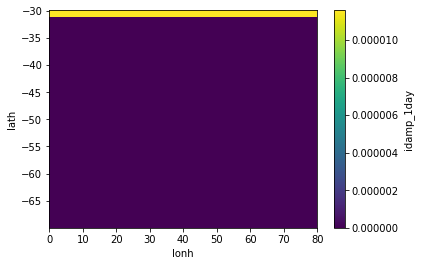

In [52]:
sponge['idamp_1day'].plot()

In [93]:
# Topography
max_depth = 4000.

Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 66.5).argmin()).values
min_shelf_depth, shelf_lat, shelf_width = (500., Ys, 1.e5)

d_shelf = (infs.make_topography(function='shelf', H=max_depth, Hs=min_shelf_depth, Y1=Y, 
                                Ys=shelf_lat, Ws=shelf_width))

bump_lat = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 52.).argmin()).values
bump_lon = X.isel(lonh = 120)

bump_width = np.abs(Y.isel(lonh =0, lath = np.abs(Y.lath.values + 46.).argmin()).values -
                    Y.isel(lonh =0, lath = np.abs(Y.lath.values + 58.).argmin()).values)
bump_length = np.abs(X.isel(lath =0, lonh = np.abs(X.lonh.values - 30.).argmin()).values -
                    X.isel(lath =0, lonh = np.abs(X.lonh.values - 50.).argmin()).values)

d_bump = (infs.make_topography(function='bump', Hs=3000., Y1=Y, X1=X, Wx=bump_length, Wy=bump_width,
                              Xs=bump_lon, Ys=bump_lat, dx=1.0, dy=1.0))

ridge_width = np.abs(X.isel(lath =0, lonh = np.abs(X.lonh.values - 37.).argmin()).values -
                    X.isel(lath =0, lonh = np.abs(X.lonh.values - 42.).argmin()).values)
ridge_length = 1.e7
ridge_lat = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 52.).argmin()).values
ridge_lon = X.isel(lonh = 120)

d_ridge = (infs.make_topography(function='ridge', Hs=2000., Y1=Y, X1=X, Wy=ridge_length, Wx=ridge_width,
                              Xs=ridge_lon, Ys=ridge_lat, theta=0.))

topography = xr.Dataset()
height = np.maximum(-d_shelf, np.minimum(d_bump, 2000.))
topography['depth_bump'] = -1*(-max_depth + height)

height = np.maximum(-d_shelf, d_ridge)
topography['depth_ridge'] = -1*(-max_depth + height)

topography.transpose('lath','lonh')
topography.to_netcdf('../../MOM6_Channel_Input/topography'+'.nc')

<xarray.Dataset>
Dimensions:      (lath: 272, lonh: 320)
Coordinates:
  * lath         (lath) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * lonh         (lonh) float64 0.125 0.375 0.625 0.875 ... 79.38 79.62 79.88
Data variables:
    depth_bump   (lath, lonh) float64 501.7 501.7 501.7 ... 4e+03 4e+03 4e+03
    depth_ridge  (lath, lonh) float64 501.7 501.7 501.7 ... 4e+03 4e+03 4e+03

Text(0.5, 0, 'Lon')

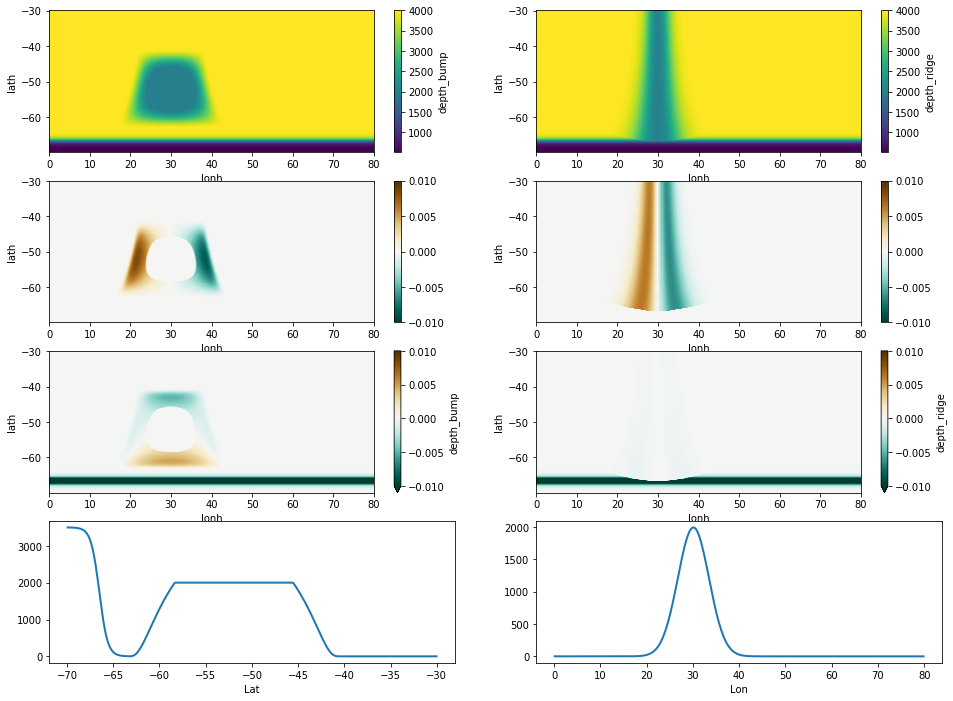

In [98]:
# Topography is a combination of bump (inspired from Kerguelen plateou) and continetal shelf. 
# Another topography is a combination of a ridge and a shelf.
# Topographic gradient magnitudes are close to reality

grady_b = - topography['depth_bump'].differentiate("lath")*360/(2*np.pi*6378100)
gradx_b = - topography['depth_bump'].differentiate("lonh")*360/(2*np.pi*6378100*np.cos(Y.lath*np.pi/180.))

grady_r = - topography['depth_ridge'].differentiate("lath")*360/(2*np.pi*6378100)
gradx_r = - topography['depth_ridge'].differentiate("lonh")*360/(2*np.pi*6378100*np.cos(Y.lath*np.pi/180.))

fig = plt.figure(figsize=[16,12])

plt.subplot(4,2,1)
topography.depth_bump.plot()

plt.subplot(4,2,2)
topography.depth_ridge.plot()

plt.subplot(4,2,3)
gradx_b.plot(cmap='BrBG_r',vmin=-1e-2, vmax=1e-2)

plt.subplot(4,2,4)
gradx_r.plot(cmap='BrBG_r',vmin=-1e-2, vmax=1e-2)

plt.subplot(4,2,5)
grady_b.plot(cmap='BrBG_r',vmin=-1e-2, vmax=1e-2)

plt.subplot(4,2,6)
grady_r.plot(cmap='BrBG_r',vmin=-1e-2, vmax=1e-2)

plt.subplot(4,2,7)
plt.plot(topography['lath'], 4000. - topography['depth_bump'].isel(lonh=120),lw=2)
plt.xlabel('Lat')

plt.subplot(4,2,8)
plt.plot(topography['lonh'], 4000. - topography['depth_ridge'].isel(lath=100),lw=2)
plt.xlabel('Lon')